In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
from numpy.linalg import inv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from numpy.random import multivariate_normal
from sklearn.svm import SVC
from scipy.stats import bernoulli

In [ ]:
dat = pd.read_csv('/content/drive/My Drive/Research 2020 fall/simulation/NAFLD.txt',sep = ' ')
## change gender to female
sex_dict = {'M':0, 'F':1}
dat['Female'] = dat.Gender.map(sex_dict)

## select relevant cols and dropna 
#dat_1 = dat.loc[:,['R1-NASH','R2-NASH', 'Female','FIB4','LSVR', 'NASH']].dropna()
dat_1 = dat.loc[:,['R1-NASH','R2-NASH','FIB4','LSVR', 'NASH']].dropna()

## X0 and X1
X0 = dat_1.loc[dat_1.NASH == 0, ['R1-NASH','R2-NASH','FIB4','LSVR']]
X1 = dat_1.loc[dat_1.NASH == 1, ['R1-NASH','R2-NASH','FIB4','LSVR']]

1. simulation(check)
2. 0.5 (check)
3. nonlinear (wait for code) (check)

# Linear combination 

Choose first var to be anchor

In [ ]:
[roc_auc_score(dat_1.NASH, dat_1.iloc[:,i]) for i in range(4)]
#[0.4643326758711374,
# 0.4276791584483892,
# 0.7143326758711374,
# 0.4819197896120973]

[0.5827580539119, 0.5613083497698882, 0.715154503616042, 0.4953977646285339]

In [ ]:
[NonpAUC(X0.iloc[:,i],X1.iloc[:,i]) for i in range(4)] 

[0.5827580539119, 0.5613083497698882, 0.715154503616042, 0.49539776462853385]

In [ ]:
def indicator(s0,s1):
  """Indicator function
  s0: scalar
  s1:scalar
  return scalar
  """
  if s0 == s1: return 0.5
  elif s1 > s0: return 1
  else: return 0

def NonpAUC(s0,s1):
  """compute the nonparametruc AUC. 
  s1: array of composite scores for class '1'.
  s0: array of composite scores for class '0'
  return scalar auc
  """
  n1 = len(s1)
  n0 = len(s0)
  ans = 0
  for x1 in s1:
    for x0 in s0:
      ans += indicator(x0,x1)
  return ans/(n1*n0)


In [ ]:
####. AUC 

### method1, more convient in suliu
#def NonpAUC(s0, s1):
#  """
#  compute the nonparametruc AUC. 
#  s1: array of composite scores for class '1'.
#  s0: array of composite scores for class '0'
#  return scalar auc
#  """
#  n1 = len(s1)
#  n0 = len(s0)
#  return sum([sum(x> s0) for x in s1])/ (n1*n0)

# method 2
## actually does not need that function,
# roc_auc_score(y, y_pred)    directly get nonpAUC

# method 3, can plot ROC curve
#fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
#metrics.auc(fpr, tpr)
# method I: plt
#plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()

In [ ]:
NonpAUC(np.array([10]),np.array([11]) )

1.0

In [ ]:
### anchor var
def anchor_est_coef(coef):
  """
  set the first var as anchor var, which has coef 1.
  coef: array(cannot be list)
  return coef_, array.
  """

  # if anchor coef <0
  coef_ = np.array(coef)
  return coef_/abs(coef_[0]) # abs guarantee it is increasing transformation

Su and Liu's method

In [ ]:
def suliu(X0, X1, bool = True):
  """
  X0: df or array, design matrix for class '0'
  X1: df or array, design matrix for class '1'
  """
  a = np.cov(X0, rowvar= False) +  np.cov(X1, rowvar= False)
  b = X1.mean().to_numpy() - X0.mean().to_numpy()
  est_coef = np.matmul(inv(a),b)
  if bool: 
    est_coef = anchor_est_coef(est_coef)
  # 
  Y0 = np.matmul(X0.to_numpy(), est_coef); Y1 = np.matmul(X1.to_numpy(), est_coef)
  auc = NonpAUC(Y0, Y1)
  if auc >=0.5:
    return est_coef, auc
  else:
    return -est_coef, 1-auc

In [ ]:
coef, auc = suliu(X0,X1, bool =False)
print('estimated coef is %s' % coef)
print('empirical AUC is %s' % auc)

estimated coef is [0.09214426 0.0608472  0.03468675 0.09459451]
empirical AUC is 0.6620644312952005


In [ ]:
coef, auc = suliu(X0,X1)
print('estimated coef is %s' % coef)
print('empirical AUC is %s' % auc)

estimated coef is [1.         0.66034715 0.37643963 1.02659137]
empirical AUC is 0.6620644312952005


random forest

In [ ]:
def randomforst(X0,X1):
  n0 = X0.shape[0]
  n1 = X1.shape[0]

  X = pd.concat([X0,X1])
  y = [0] * n0
  y.extend([1]*n1); y = np.array(y)
  rf =RandomForestClassifier(max_depth=2, random_state=43).fit(X,y)
  ## 
  y_pred = rf.predict_proba(X)[:,1]
  auc = roc_auc_score(y, y_pred)
  #print(NonpAUC(y_pred[:n0], y_pred[n0:]))
  #feature_importances = rf.feature_importances_
  return rf, auc ## return model, for future prediction

In [ ]:
mod_rf, auc = randomforst(X0,X1)
#print('estimated feature_importances_ is %s' % coef)
print('empirical AUC is %s' % auc)

0.7943786982248521
empirical AUC is 0.7943786982248521


SVM_r

In [ ]:
def svm_r(X0,X1):
  """svm with rbf kernel
  X0: df, design matrix for class '0'
  X1: df, design matrix for class '1'
  """
  n0 = X0.shape[0]
  n1 = X1.shape[0]

  X = pd.concat([X0,X1])
  y = [0] * n0
  y.extend([1]*n1); y = np.array(y)
  mod = SVC(kernel = 'rbf',random_state=42, probability= True).fit(X,y)
  ## 
  y_pred = mod.predict_proba(X)[:,1]
  auc = roc_auc_score(y, y_pred)

  return mod, auc ## cannot return estimates, so return mod for future prediction


In [ ]:
mod_svm,auc = svm_r(X0,X1)
print('empirical AUC is %s' % auc)

empirical AUC is 0.723044049967127


SVM_l

In [ ]:
def svm_l(X0,X1):
  """svm with linear kernel
  X0: df, design matrix for class '0'
  X1: df, design matrix for class '1'
  """
  n0 = X0.shape[0]
  n1 = X1.shape[0]

  X = pd.concat([X0,X1])
  y = [0] * n0
  y.extend([1]*n1); y = np.array(y)
  mod = SVC(kernel = 'linear',random_state=0, probability= True).fit(X,y)
  ## 
  y_pred = mod.predict_proba(X)[:,1]
  auc = roc_auc_score(y, y_pred)

  return mod, auc ## cannot return estimates, so return mod for future prediction


In [ ]:
mod_svm,auc = svm_l(X0,X1)
print('empirical AUC is %s' % auc)

empirical AUC is 0.7140861275476659


Logistic regression

In [ ]:
def logistic(X0,X1, bool = True):
  n0 = X0.shape[0]
  n1 = X1.shape[0]

  X = pd.concat([X0,X1])
  y = [0] * n0
  y.extend([1]*n1); y = np.array(y)
  lr = LR(random_state=0).fit(X,y)
  ## 
  y_pred = lr.predict_proba(X)[:,1]
  auc = roc_auc_score(y, y_pred)
  est_coef = lr.coef_[0]
  if bool: 
    est_coef = anchor_est_coef(est_coef)

  if auc >=0.5:
    return est_coef, auc
  else:
    return -est_coef, 1-auc


In [ ]:
coef, auc = logistic(X0,X1,bool = False)
print('estimated coef is %s' % coef)
print('empirical AUC is %s' % auc)

estimated coef is [ 0.08983826  0.15290624  0.33386934 -0.43478166]
empirical AUC is 0.7140039447731755


In [ ]:
coef, auc = logistic(X0,X1)
print('estimated coef is %s' % coef)
print('empirical AUC is %s' % auc)

estimated coef is [ 1.          1.70201691  3.71633799 -4.83960459]
empirical AUC is 0.7140039447731755


Pepe method

In [ ]:
def nonp_combine2_auc(l1,l2, X0, X1):
  """
  compute nonparametric AUC when X0 and X1 has two cols for given coef (l1,l2)
  l1: first coef
  l2: second coef
  X0: df, design matrix for class '0'
  X1: df, design matrix for class '1'
  """
  n0 = X0.shape[0]
  n1 = X1.shape[0]
  s0 = np.matmul(X0.to_numpy(), np.array([l1,l2]))
  s1 = np.matmul(X1.to_numpy(), np.array([l1,l2]))
  return NonpAUC(s0,s1)


def pepe(X0,X1, evalnum = 201, bool = True):
  """
  compute the coef that has max nonparametric AUC, X0 and X1 has two cols.
  X0: df, design matrix for class '0'
  X1: df, design matrix for class '1'
  """

  l = np.linspace(start=-1, stop=1, num=evalnum)
  #l2 = np.linspace(start=-1, stop=1, num=evalnum)
  auc_l1 = [nonp_combine2_auc(e,1,X0,X1) for e in l]  
  auc_l2 = [nonp_combine2_auc(1,e,X0,X1) for e in l] 
  if max(auc_l1) > max(auc_l2):
    ind = auc_l1.index(max(auc_l1))
    est_coef = np.array([l[ind],1])
    if bool: 
      est_coef = anchor_est_coef(est_coef)
    return est_coef, max(auc_l1)
  
  else:
    ind = auc_l2.index(max(auc_l2))
    est_coef = np.array([1,l[ind]])
    if bool: 
      est_coef = anchor_est_coef(est_coef)
    return est_coef, max(auc_l2)

In [ ]:
X0_2 = X0.loc[:,['FIB4','LSVR']]; X1_2 = X1.loc[:,['FIB4','LSVR']]
coef, auc = pepe(X0_2,X1_2, bool = False)
print('estimated coef is %s' % coef)
print('empirical AUC is %s' % auc)

estimated coef is [ 1.   -0.76]
empirical AUC is 0.7164694280078896


Min-max

In [ ]:
def liu(X0, X1, bool = True):
  """
  X0: df, design matrix for class '0'
  X1: df, design matrix for class '1'
  """
  # get min max row-wise
  max_min_X0 = np.concatenate( (  np.amax(X0.to_numpy(), axis=1).reshape(-1,1) , np.amin(X0.to_numpy(), axis=1).reshape(-1,1)  ), axis =1 ) 
  max_min_X1 = np.concatenate( (  np.amax(X1.to_numpy(), axis=1).reshape(-1,1) , np.amin(X1.to_numpy(), axis=1).reshape(-1,1)  ), axis =1 ) 
  max_min_X0 = pd.DataFrame(data = max_min_X0); max_min_X1 = pd.DataFrame(data = max_min_X1)
  return pepe(max_min_X0, max_min_X1, bool = bool)
  

In [ ]:
coef, auc = liu(X0,X1, bool = False)
print('estimated coef is %s' % coef)
print('empirical AUC is %s' % auc)

estimated coef is [ 1.   -0.94]
empirical AUC is 0.6338757396449705


stepwise

In [ ]:
def auc_check(X0, X1):
  """calculate AUC for every var
  X0: df, design matrix for class '0'
  X1: df, design matrix for class '1'
  """
  p = X0.shape[1]
  auc_list = []
  for i in list(X0.columns):
    auc_list.append(NonpAUC(X0.loc[:,i], X1.loc[:,i] ) )

  return auc_list

In [ ]:
auc_check(X0,X1)

[0.5827580539119, 0.5613083497698882, 0.715154503616042, 0.49539776462853385]

In [ ]:
def stepwise(X0, X1, bool = True):
  n0 = X0.shape[0]
  n1 = X1.shape[0]
  varnum = X0.shape[1]
  combcoef = []
  ## step down
  auc_order = np.array(auc_check(X0,X1))
  sort_index = np.argsort(auc_order); sort_index= sort_index[::-1] ## auc_order[sort_index[0]] largest,  auc_order[sort_index[len()]] smallest
  combmarker0 = X0.iloc[:,[sort_index[0]]].copy() # pd
  combmarker1 = X1.iloc[:,[sort_index[0]]].copy() # pd
  nal_coef = [1]
  for i in range(1,varnum):
    #combmarker0 = pd.concat([combmarker0, X0.iloc[:, [sort_index[i]] ] ], axis= 1,ignore_index = True)
    #combmarker1 = pd.concat([combmarker1, X1.iloc[:, [sort_index[i]] ] ], axis= 1,ignore_index = True)
    combmarker0['new'] =  X0.iloc[:, [ sort_index[i] ] ].to_numpy() 
    combmarker1['new'] =  X1.iloc[:, [ sort_index[i] ] ].to_numpy()
    temp_inf , _ = pepe(combmarker0,combmarker1, bool= False)
    #print(temp_inf)
    combcoef.append(temp_inf)
    nal_coef = temp_inf[0]*np.array(nal_coef); nal_coef = list(nal_coef); nal_coef.append(temp_inf[1])
    combmarker0 = pd.DataFrame(data = np.matmul( combmarker0.to_numpy(),  temp_inf))
    combmarker1 = pd.DataFrame(data = np.matmul( combmarker1.to_numpy(),  temp_inf))
  
  est_coef = np.array([0.]*varnum) ## None has dtype problem, 0. makes float dtype. 
  for i in range(varnum):
    est_coef[sort_index[i]] = nal_coef[i]
  auc = NonpAUC( np.matmul(X0.to_numpy() ,est_coef ) , np.matmul(X1.to_numpy() ,est_coef ))
  
  if auc >=0.5:
    return est_coef, auc
  else:
    return -est_coef, 1-auc


In [ ]:
coef, auc = stepwise(X0,X1)
print('estimated coef is %s' % coef)
print('empirical AUC is %s' % auc)

estimated coef is [ 0.29  0.03  1.   -0.16]
empirical AUC is 0.7271531886916502


In [ ]:
coef

array([ 0.24, -0.01,  1.  , -0.76])

# Resubstitution

In [ ]:
class AllMethod:
  def __init__(self, method, bool_trans = True):
    """
    method: a string, specify which linear combination method to use. ['suliu', 'pepe', 'min-max','stepwise', 'rf', 'svml', 'svmr', 'logistic']
    bool_trans: whether to perform log transformation
    """
    self.method = method
    self.bool_trans = bool_trans
  def fit(self, X0, X1):
    """Train the model
    X0: df, design matrix for class '0'
    X1: df, design matrix for class '1'
    return: self, 
    obtain self.coef_ or self.mod, and self.fitted_auc 
    """
    if self.bool_trans:
      X0 = np.log(X0); X1 = np.log(X1)

    if self.method == 'suliu':
      self.coef_, self.fiited_auc_ = suliu(X0,X1,bool=False)
      
    elif self.method == 'logistic':
      self.coef_, self.fiited_auc_ = logistic(X0,X1,bool=False)

    elif self.method == 'min-max':
      self.coef_, self.fiited_auc_ = liu(X0,X1,bool=False)
    
    elif self.method == 'stepwise':
      self.coef_, self.fiited_auc_ = stepwise(X0,X1,bool=False)

    elif self.method == 'pepe':
      if X0.shape[1] != 2: 
        raise ValueError("Passed array is not of the right shape")
      self.coef_, self.fiited_auc_ = pepe(X0,X1,bool=False)

    elif self.method == 'svml':
      self.mod_, self.fiited_auc_ = svm_l(X0,X1)

    elif self.method == 'svmr':
      self.mod_, self.fiited_auc_ = svm_r(X0,X1)

    elif self.method == 'rf':
      self.mod_, self.fiited_auc_ = randomforst(X0,X1)
    return self

  def predict(self, X0, X1):
    """predict 
    X0: df, design matrix for class '0'
    X1: df, design matrix for class '1'
    return: y0, y1
    """

    if self.bool_trans:
      X0 = np.log(X0); X1 = np.log(X1)
    
    if self.method in ['rf', 'svml', 'svmr']: ## no self.coef_ , self.mod_
      y0 = self.mod_.predict_proba(X0)[:,1]
      y1 = self.mod_.predict_proba(X1)[:,1]
      auc = NonpAUC(y0, y1)
      return y0, y1, auc

    else: ## other methods, which return self.coef_
      if self.method == 'min-max':
        max_min_X0 = np.concatenate( (  np.amax(X0.to_numpy(), axis=1).reshape(-1,1) , np.amin(X0.to_numpy(), axis=1).reshape(-1,1)  ), axis =1 ) 
        max_min_X1 = np.concatenate( (  np.amax(X1.to_numpy(), axis=1).reshape(-1,1) , np.amin(X1.to_numpy(), axis=1).reshape(-1,1)  ), axis =1 ) 
        X0 = pd.DataFrame(data = max_min_X0); X1 = pd.DataFrame(data = max_min_X1)
      
      y0 = np.matmul(X0.to_numpy(), self.coef_ )
      y1 = np.matmul(X1.to_numpy(), self.coef_ )
      auc = NonpAUC(y0, y1)
      return y0, y1, auc

  
  def roc_plot(self, X0, X1):
    #if self.bool_trans:
    #  X0 = np.log(X0); X1 = np.log(X1) ## in self.predict, already did the transformation!

    n0 = X0.shape[0]; n1 = X1.shape[0]
    y0, y1, auc = self.predict(X0,X1); #print(y0); print(y1)
    y = [0] * n0
    y.extend([1]*n1); y = np.array(y); #print(y)
    y_pred = np.concatenate((y0,y1)); #print(y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    plt.title('Receiver Operating Characteristic, Method: % s' % self.method)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

estimated coef is [ 0.21321549  0.16823261  0.4881565  -0.17820335]
fitted AUC is 0.7310979618671927


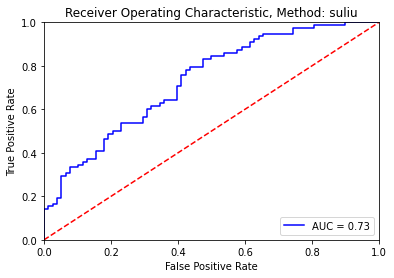

In [ ]:
lc = AllMethod(method= 'suliu')
lc.fit(X0,X1)
print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0,X1)

estimated coef is [ 0.3739178   0.32003469  0.95818109 -0.29334323]
fitted AUC is 0.7287968441814595


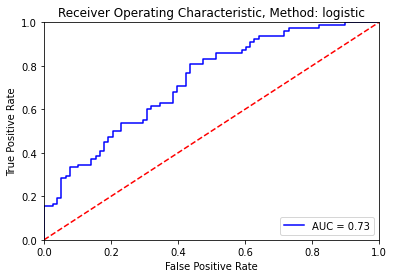

In [ ]:
lc = AllMethod(method= 'logistic')
lc.fit(X0,X1)
print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0,X1)

fitted AUC is 0.7962689020381327


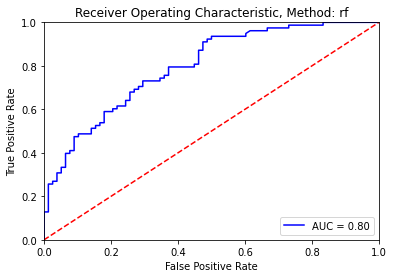

In [ ]:
lc = AllMethod(method= 'rf')
lc.fit(X0,X1)
#print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0,X1)

fitted AUC is 0.7294543063773833


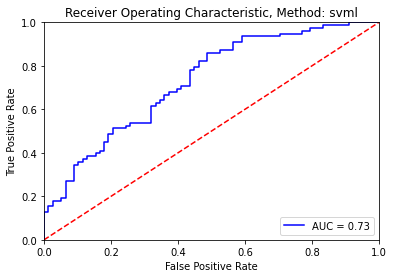

In [ ]:
lc = AllMethod(method= 'svml')
lc.fit(X0,X1)
#print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0,X1)

fitted AUC is 0.7427679158448389


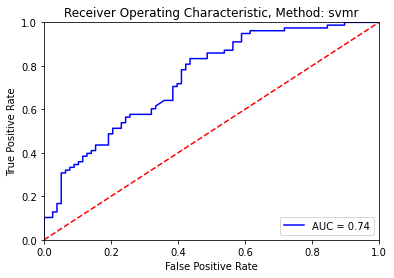

In [ ]:
lc = AllMethod(method= 'svmr')
lc.fit(X0,X1)
#print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0,X1)

estimated coef is [ 0.97 -0.04  1.    0.  ]
fitted AUC is 0.7357001972386588


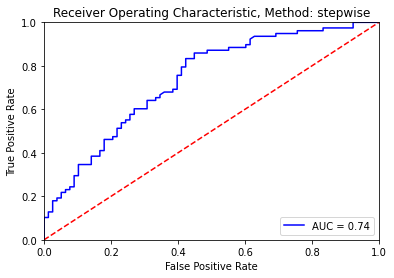

In [ ]:
lc = AllMethod(method= 'stepwise')
lc.fit(X0,X1)
print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0,X1)

estimated coef is [ 1.   -0.11]
fitted AUC is 0.6351906640368179


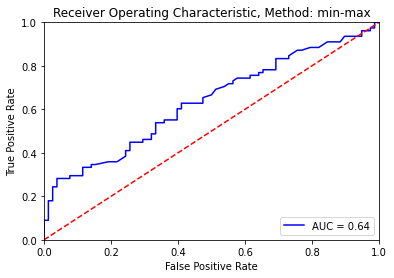

In [ ]:
lc = AllMethod(method= 'min-max')
lc.fit(X0,X1)
print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0,X1)

estimated coef is [ 1.   -0.09]
fitted AUC is 0.7159763313609467


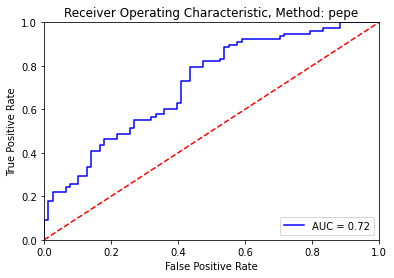

In [ ]:
lc = AllMethod(method= 'pepe')
lc.fit(X0_2,X1_2)
print('estimated coef is %s' % lc.coef_)
print('fitted AUC is %s' % lc.fiited_auc_)
lc.roc_plot(X0_2,X1_2)

# LOOPV

$\hat{AUC}^{cv} = \frac{1}{n_1 n_2} \sum_i \sum_j I(X_i \hat{c}^{-ij} < Y_j \hat{c}^{-ij})$, 10-fold CV can be applied instead of LOPO CV to gain efficiency

In [ ]:
X = dat_1.loc[:, ['R1-NASH', 'R2-NASH', 'FIB4','LSVR']]
Y = dat_1.loc[:,'NASH']

In [ ]:
def helper(X, Y):
  """Take X, Y, return X0 and X1
  X: df/array
  Y: df.series
  return X0, X1
  """
  #try:
  X0 = X.loc[Y == 0].copy()
  #except:
  #  X0 = X[Y == 0]
  #try:
  X1 = X.loc[Y == 1].copy()
  #except:
    #X1 = X[Y == 1]
  return X0,X1

In [ ]:
def get_cv(method,bool_trans,X,Y,n_splits=10,cv_type = "StratifiedKFold",verbose = True):  
  """Cross validation to get AUC.
  method: str, ['suliu', 'pepe', 'min-max','stepwise', 'logistic']
  X: design matrix
  Y: labels
  bool_trans: whether applied log transformation of X
  """
  if cv_type == "StratifiedKFold":
    cv = StratifiedKFold(n_splits= n_splits, shuffle=True, random_state=42) # The folds are made by preserving the percentage of samples for each class.
  else: 
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  
  model = AllMethod(method= method, bool_trans= bool_trans)
  #training_time = []
  AUC = []

  for folder, (train_index, val_index) in enumerate(cv.split(X, Y)): 
    X_train,X_val = X.iloc[train_index],X.iloc[val_index]
    y_train,y_val = Y.iloc[train_index],Y.iloc[val_index]
    # 
    X0_train, X1_train = helper(X_train, y_train); X0_val, X1_val = helper(X_val, y_val)

    model.fit(X0_train,X1_train)
    _,_, auc = model.predict(X0_val,X1_val)
    AUC.append(auc)
    if verbose:
        #print('estimated coef is %s' % model.coef_)
        print('fitted AUC is %s' % model.fiited_auc_)
        print("test auc in %s fold is %s" % (folder+1,auc) )
        print('____'*10)
  return AUC      




In [ ]:
AUC = get_cv('svml',True,X,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

fitted AUC is 0.726938775510204
test auc in 1 fold is 0.796875
________________________________________
fitted AUC is 0.7312244897959184
test auc in 2 fold is 0.703125
________________________________________
fitted AUC is 0.7446938775510205
test auc in 3 fold is 0.46875
________________________________________
fitted AUC is 0.72
test auc in 4 fold is 0.703125
________________________________________
fitted AUC is 0.7138775510204083
test auc in 5 fold is 0.8125
________________________________________
fitted AUC is 0.7410204081632652
test auc in 6 fold is 0.6875
________________________________________
fitted AUC is 0.7372233400402414
test auc in 7 fold is 0.6607142857142857
________________________________________
fitted AUC is 0.7344064386317908
test auc in 8 fold is 0.6339285714285714
________________________________________
fitted AUC is 0.7272635814889337
test auc in 9 fold is 0.8214285714285714
________________________________________
fitted AUC is 0.7458752515090543
test auc in 

In [ ]:
AUC = get_cv('svmr',True,X,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

fitted AUC is 0.741326530612245
test auc in 1 fold is 0.65625
________________________________________
fitted AUC is 0.7395918367346939
test auc in 2 fold is 0.703125
________________________________________
fitted AUC is 0.7653061224489796
test auc in 3 fold is 0.5
________________________________________
fitted AUC is 0.7428571428571429
test auc in 4 fold is 0.703125
________________________________________
fitted AUC is 0.723265306122449
test auc in 5 fold is 0.890625
________________________________________
fitted AUC is 0.7476530612244897
test auc in 6 fold is 0.59375
________________________________________
fitted AUC is 0.7467806841046278
test auc in 7 fold is 0.5892857142857143
________________________________________
fitted AUC is 0.7505030181086519
test auc in 8 fold is 0.6428571428571429
________________________________________
fitted AUC is 0.7442655935613682
test auc in 9 fold is 0.7678571428571429
________________________________________
fitted AUC is 0.7575452716297786
t

In [ ]:
AUC = get_cv('rf',True,X,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

fitted AUC is 0.803265306122449
test auc in 1 fold is 0.703125
________________________________________
fitted AUC is 0.7903061224489796
test auc in 2 fold is 0.703125
________________________________________
fitted AUC is 0.8291836734693878
test auc in 3 fold is 0.53125
________________________________________
fitted AUC is 0.8057142857142856
test auc in 4 fold is 0.75
________________________________________
fitted AUC is 0.8089795918367346
test auc in 5 fold is 0.625
________________________________________
fitted AUC is 0.8033673469387755
test auc in 6 fold is 0.703125
________________________________________
fitted AUC is 0.8064386317907445
test auc in 7 fold is 0.5892857142857143
________________________________________
fitted AUC is 0.808148893360161
test auc in 8 fold is 0.625
________________________________________
fitted AUC is 0.8009054325955735
test auc in 9 fold is 0.7142857142857143
________________________________________
fitted AUC is 0.802112676056338
test auc in 10 f

In [ ]:
AUC = get_cv('suliu',True,X,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

estimated coef is [ 0.16423173  0.17192216  0.47342439 -0.12295693]
fitted AUC is 0.7267346938775511
test auc in 1 fold is 0.765625
________________________________________
estimated coef is [ 0.21731215  0.1442442   0.48624776 -0.16141146]
fitted AUC is 0.7289795918367347
test auc in 2 fold is 0.734375
________________________________________
estimated coef is [ 0.13931094  0.13529973  0.55098935 -0.27915203]
fitted AUC is 0.746938775510204
test auc in 3 fold is 0.5
________________________________________
estimated coef is [ 0.12425578  0.23213496  0.48220717 -0.28767322]
fitted AUC is 0.7197959183673469
test auc in 4 fold is 0.75
________________________________________
estimated coef is [ 0.24492085  0.11601341  0.45365693 -0.28462872]
fitted AUC is 0.7140816326530612
test auc in 5 fold is 0.8125
________________________________________
estimated coef is [ 0.24570791  0.2356877   0.49591478 -0.0419022 ]
fitted AUC is 0.7381632653061224
test auc in 6 fold is 0.6875
_________________

In [ ]:
AUC = get_cv('logistic',True,X,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

estimated coef is [ 0.28158991  0.32233219  0.92826485 -0.18068051]
fitted AUC is 0.7244897959183674
test auc in 1 fold is 0.75
________________________________________
estimated coef is [ 0.373677    0.27618509  0.95155479 -0.25891987]
fitted AUC is 0.7308163265306122
test auc in 2 fold is 0.734375
________________________________________
estimated coef is [ 0.24383946  0.24615408  1.08274099 -0.44774212]
fitted AUC is 0.7479591836734694
test auc in 3 fold is 0.5
________________________________________
estimated coef is [ 0.22811827  0.40137934  0.93614165 -0.4649891 ]
fitted AUC is 0.7189795918367347
test auc in 4 fold is 0.765625
________________________________________
estimated coef is [ 0.41094614  0.23594975  0.88292317 -0.46491883]
fitted AUC is 0.7138775510204082
test auc in 5 fold is 0.828125
________________________________________
estimated coef is [ 0.44093755  0.44058256  0.94531732 -0.06193732]
fitted AUC is 0.7375510204081632
test auc in 6 fold is 0.6875
______________

In [ ]:
AUC = get_cv('min-max',True,X,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

estimated coef is [1.   0.33]
fitted AUC is 0.6337755102040816
test auc in 1 fold is 0.71875
________________________________________
estimated coef is [ 1.   -0.11]
fitted AUC is 0.6323469387755102
test auc in 2 fold is 0.671875
________________________________________
estimated coef is [ 1.   -0.11]
fitted AUC is 0.6410204081632653
test auc in 3 fold is 0.5625
________________________________________
estimated coef is [ 1.   -0.11]
fitted AUC is 0.6159183673469387
test auc in 4 fold is 0.796875
________________________________________
estimated coef is [ 1.   -0.79]
fitted AUC is 0.626938775510204
test auc in 5 fold is 0.4921875
________________________________________
estimated coef is [1.   0.09]
fitted AUC is 0.6294897959183674
test auc in 6 fold is 0.671875
________________________________________
estimated coef is [ 1.   -0.11]
fitted AUC is 0.6224346076458752
test auc in 7 fold is 0.7321428571428571
________________________________________
estimated coef is [ 1.   -0.11]
fitted

In [ ]:
AUC = get_cv('stepwise',True,X,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

estimated coef is [ 0.97  0.03  1.   -0.15]
fitted AUC is 0.733265306122449
test auc in 1 fold is 0.8125
________________________________________
estimated coef is [ 0.97 -0.04  1.    0.  ]
fitted AUC is 0.7374489795918368
test auc in 2 fold is 0.71875
________________________________________
estimated coef is [0.45 0.09 1.   0.  ]
fitted AUC is 0.7518367346938776
test auc in 3 fold is 0.578125
________________________________________
estimated coef is [ 0.97  0.    1.   -0.12]
fitted AUC is 0.723265306122449
test auc in 4 fold is 0.84375
________________________________________
estimated coef is [ 0.97 -0.04  1.   -0.08]
fitted AUC is 0.7222448979591837
test auc in 5 fold is 0.859375
________________________________________
estimated coef is [0.97 0.44 1.   0.39]
fitted AUC is 0.740204081632653
test auc in 6 fold is 0.671875
________________________________________
estimated coef is [0.93 0.02 1.   0.  ]
fitted AUC is 0.7421529175050302
test auc in 7 fold is 0.6428571428571429
_______

In [ ]:
X_2 = X.loc[:,['FIB4','LSVR']]
AUC = get_cv('pepe',True,X_2,Y, 10)
print("%s +/- %s" % (np.mean(AUC), np.std(AUC) ) )

estimated coef is [1.   0.15]
fitted AUC is 0.7171428571428572
test auc in 1 fold is 0.703125
________________________________________
estimated coef is [1.   0.15]
fitted AUC is 0.716530612244898
test auc in 2 fold is 0.6875
________________________________________
estimated coef is [ 1.   -0.09]
fitted AUC is 0.7446938775510205
test auc in 3 fold is 0.5
________________________________________
estimated coef is [ 1.   -0.23]
fitted AUC is 0.7073469387755102
test auc in 4 fold is 0.703125
________________________________________
estimated coef is [ 1. -1.]
fitted AUC is 0.6989795918367347
test auc in 5 fold is 0.734375
________________________________________
estimated coef is [1.   0.15]
fitted AUC is 0.71
test auc in 6 fold is 0.796875
________________________________________
estimated coef is [1.   0.14]
fitted AUC is 0.7259557344064387
test auc in 7 fold is 0.5892857142857143
________________________________________
estimated coef is [ 1.   -0.23]
fitted AUC is 0.7209255533199195


# Simulation

## Multivariate normal with equal variance

In [ ]:
_ = MonteCarlo_1(10, 20, 20, u0, u1, sigma, sigma)

{'suliu': (0.775, 0.14958275301651588), 'logistic': (0.7699999999999999, 0.1523975065412817), 'stepwise': (0.7749999999999999, 0.10246950765959599), 'min-max': (0.7474999999999999, 0.13984366270946993), 'rf': (0.7375, 0.13428049001995782), 'svml': (0.77625, 0.12629949524839756), 'svmr': (0.71375, 0.18204137579132937)}


In [ ]:
u0 = [0.1,0.1,0.1, 0.1]; u1 = [0.6, 0.8, 1, 1.2]
sigma = [[1,0.5,0.5,0.5],
          [0.5,1,0.5,0.5],
          [0.5,0.5,1,0.5],
          [0.5,0.5,0.5,1]]

In [ ]:
def MonteCarlo_1(T, n0, n1, u0, u1, sigma0, sigma1, log_bool = False):
  """simulation for first scenario: multivarite normal with equal variance
  T: number of simulation
  n0: sample size of class 0
  n1: sample size of class 1
  """
  AUC = {'suliu':[], 'logistic':[], 'stepwise':[],'min-max':[], 'rf':[], 'svml':[], 'svmr':[]}  ## same num as simulation time
  methods = ['suliu', 'logistic', 'stepwise','min-max', 'rf', 'svml', 'svmr']
  for i in range(T):
    ### one monto carlo simulation of size n0 + n1
    #i = 10
    np.random.seed(seed= 100*i+ 4*i)
    X0 = multivariate_normal(u0, sigma0, size = n0)
    X1 = multivariate_normal(u1, sigma1, size = n1)
    if log_bool:
      X0 = np.exp(X0)
      X1 = np.exp(X1)
    #
    X = np.concatenate([X0,X1])
    y = [0] * n0
    y.extend([1]*n1); y = np.array(y) ## X,y is one simulation
    X = pd.DataFrame(data = X); y = pd.Series(y)
    ## within that particular MC simulation, do 10 folds CV
    cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)
    AUC_folds = {'suliu':[], 'logistic':[], 'stepwise':[],'min-max':[], 'rf':[], 'svml':[], 'svmr':[]}  # same number as folders
    #
    for folder, (train_index, val_index) in enumerate(cv.split(X, y)): 
        X_train,X_val = X.iloc[train_index],X.iloc[val_index]
        y_train,y_val = y.iloc[train_index],y.iloc[val_index]
        # 
        X0_train, X1_train = helper(X_train, y_train); X0_val, X1_val = helper(X_val, y_val)
        for method in methods:
          model = AllMethod(method= method, bool_trans= False).fit(X0_train,X1_train)
          _,_, auc = model.predict(X0_val,X1_val)
          AUC_folds[method].append(auc)
    #print(AUC_folds)
    for key, val in AUC_folds.items():
      AUC[key].append( np.mean(np.array(val) ))

  print({key: (np.mean(np.array(val)) ,np.std(np.array(val))) for key,val in AUC.items()})
  return AUC

###Setting A

In [ ]:
_ = MonteCarlo_1(1000, 20, 20, u0, u1, sigma, sigma)

{'suliu': (0.762675, 0.09834871313342133), 'logistic': (0.771375, 0.09712097803770306), 'stepwise': (0.752, 0.10482604638161262), 'min-max': (0.73405, 0.10478834620319188), 'rf': (0.742525, 0.10567668557917588), 'svml': (0.7287, 0.16157543903700217), 'svmr': (0.6635625, 0.19517531181927186)}


In [ ]:
_ = MonteCarlo_1(1000, 20, 30, u0, u1, sigma, sigma)

{'suliu': (0.76875, 0.08583151292567964), 'logistic': (0.7751333333333333, 0.08300591679044465), 'stepwise': (0.7576166666666667, 0.0920117006448395), 'min-max': (0.7386, 0.09082055567619773), 'rf': (0.7493416666666666, 0.09111377159902888), 'svml': (0.7528916666666666, 0.1208156857802643), 'svmr': (0.7232, 0.1256332139382116)}


In [ ]:
_ = MonteCarlo_1(1000, 50, 50, u0, u1, sigma, sigma)

{'suliu': (0.786708, 0.054775274860104556), 'logistic': (0.7880280000000001, 0.054243149023632496), 'stepwise': (0.780832, 0.057442108039312094), 'min-max': (0.753992, 0.0542533311051036), 'rf': (0.770222, 0.056831986732825045), 'svml': (0.7854140000000001, 0.05588384922318793), 'svmr': (0.7533920000000001, 0.07719796847067935)}


### Setting B

In [ ]:
u0 = [0.1,0.1,0.1, 0.1]; u1 = [1.1, 1.4, 1.7, 2]
sigma = [[1,0.5,0.5,0.5],
          [0.5,1,0.5,0.5],
          [0.5,0.5,1,0.5],
          [0.5,0.5,0.5,1]]

In [ ]:
_ = MonteCarlo_1(1000, 20, 20, u0, u1, sigma, sigma)

{'suliu': (0.90675, 0.06063775638989292), 'logistic': (0.913875, 0.058089236309319815), 'stepwise': (0.89665, 0.06293868047552316), 'min-max': (0.88485, 0.0668990097086646), 'rf': (0.8986500000000001, 0.06218964946034026), 'svml': (0.9086124999999999, 0.06123759951002325), 'svmr': (0.89535, 0.06571674063737488)}


In [ ]:
_ = MonteCarlo_1(1000, 20, 30, u0, u1, sigma, sigma)

{'suliu': (0.9129499999999999, 0.04975292007064064), 'logistic': (0.9178, 0.04781148165219081), 'stepwise': (0.9058499999999999, 0.05317110483043295), 'min-max': (0.8894833333333334, 0.05609228259454831), 'rf': (0.9019916666666666, 0.05290707196480343), 'svml': (0.9135333333333333, 0.0507749829038759), 'svmr': (0.8980083333333333, 0.056786563722807215)}


In [ ]:
_ = MonteCarlo_1(1000, 50, 50, u0, u1, sigma, sigma)

{'suliu': (0.921284, 0.030369974382603606), 'logistic': (0.9227240000000001, 0.0301360220334403), 'stepwise': (0.9190799999999999, 0.03145767950755426), 'min-max': (0.8989040000000001, 0.03385543950386702), 'rf': (0.912004, 0.03285239692929573), 'svml': (0.920322, 0.030783442237670555), 'svmr': (0.906374, 0.035153038616882036)}


## Multivariate with uneual variance

In [ ]:
u0 = [0.1,0.1,0.1, 0.1]; u1 = [0.6, 0.8, 1, 1.2]
sigma0 = [[1,0.3,0.3,0.3],
          [0.3,1,0.3,0.3],
          [0.3,0.3,1,0.3],
          [0.3,0.3,0.3,1]]

sigma1 = [[1,0.7,0.7,0.7],
          [0.7,1,0.7,0.7],
          [0.7,0.7,1,0.7],
          [0.7,0.7,0.7,1]]



### setting A

In [ ]:
_ = MonteCarlo_1(1000, 20, 20, u0, u1, sigma0, sigma1)

{'suliu': (0.758225, 0.10298895268425638), 'logistic': (0.769225, 0.09986753413897832), 'stepwise': (0.74675, 0.10633996191460668), 'min-max': (0.790825, 0.08806358143409795), 'rf': (0.7550875000000001, 0.10263051979674467), 'svml': (0.7246625, 0.1633268726932283), 'svmr': (0.723225, 0.18155914842001214)}


In [ ]:
_ = MonteCarlo_1(1000, 20, 30, u0, u1, sigma0, sigma1)

{'suliu': (0.7658, 0.08519144453653912), 'logistic': (0.7711333333333334, 0.08501335842743252), 'stepwise': (0.7544166666666666, 0.09179199765411654), 'min-max': (0.7945166666666668, 0.0761992253533095), 'rf': (0.77115, 0.08294850979841517), 'svml': (0.7421166666666666, 0.12953900206329969), 'svmr': (0.77435, 0.10837496507752867)}


In [ ]:
_ = MonteCarlo_1(1000, 50, 50, u0, u1, sigma0, sigma1)

{'suliu': (0.787756, 0.05329184237760975), 'logistic': (0.789188, 0.053226879074392504), 'stepwise': (0.781864, 0.0563947293991203), 'min-max': (0.803432, 0.048606803803582906), 'rf': (0.786126, 0.05288731534120447), 'svml': (0.78617, 0.05482575216082314), 'svmr': (0.806996, 0.053146664843619316)}


### Setting B

In [ ]:
u0 = [0.1,0.1,0.1, 0.1]; u1 = [1.1, 1.4, 1.7, 2]
sigma0 = [[1,0.3,0.3,0.3],
          [0.3,1,0.3,0.3],
          [0.3,0.3,1,0.3],
          [0.3,0.3,0.3,1]]

sigma1 = [[1,0.7,0.7,0.7],
          [0.7,1,0.7,0.7],
          [0.7,0.7,1,0.7],
          [0.7,0.7,0.7,1]]



In [ ]:
_ = MonteCarlo_1(1000, 20, 20, u0, u1, sigma0, sigma1)

{'suliu': (0.9067499999999998, 0.06120202202542004), 'logistic': (0.913625, 0.05704151448725743), 'stepwise': (0.8965749999999999, 0.06166558501303624), 'min-max': (0.890575, 0.0636635246825056), 'rf': (0.898925, 0.06109751938499631), 'svml': (0.9083, 0.05971429895761986), 'svmr': (0.9038624999999999, 0.06123407828774759)}


In [ ]:
_ = MonteCarlo_1(1000, 20, 30, u0, u1, sigma0, sigma1)

{'suliu': (0.9105666666666666, 0.05049214460355855), 'logistic': (0.9164166666666668, 0.0474364340752736), 'stepwise': (0.9023166666666667, 0.05169805229514079), 'min-max': (0.8945833333333334, 0.055023669149436655), 'rf': (0.9070333333333334, 0.04938768402479846), 'svml': (0.9097916666666668, 0.050848614506417214), 'svmr': (0.90935, 0.0518552445649318)}


In [ ]:
_ = MonteCarlo_1(1000, 50, 50, u0, u1, sigma0, sigma1)

{'suliu': (0.9217560000000001, 0.0310952804135933), 'logistic': (0.9230640000000001, 0.030761857941288252), 'stepwise': (0.919452, 0.03167995732320356), 'min-max': (0.9034880000000001, 0.03422738459187321), 'rf': (0.913842, 0.03188797635473282), 'svml': (0.9209820000000001, 0.031100862946227062), 'svmr': (0.918258, 0.03170024346909656)}


## Log normal with unequal variance

### Setting A

In [ ]:
_ = MonteCarlo_1(1000, 20, 20, u0, u1, sigma0, sigma1, True)

{'suliu': (0.719, 0.10611432514038809), 'logistic': (0.739975, 0.10579520015104654), 'stepwise': (0.7352000000000001, 0.11355487660157973), 'min-max': (0.7912750000000001, 0.08878766454299833), 'rf': (0.7548250000000001, 0.1025434389661279), 'svml': (0.6974124999999999, 0.16492145431613803), 'svmr': (0.5792375, 0.2261961534680685)}


In [ ]:
_ = MonteCarlo_1(1000, 20, 30, u0, u1, sigma0, sigma1, True)

{'suliu': (0.7302000000000001, 0.08767467644017223), 'logistic': (0.7467, 0.09148587626270821), 'stepwise': (0.7438166666666667, 0.09799852464875854), 'min-max': (0.7945, 0.07809022559407376), 'rf': (0.7708666666666667, 0.0833599890701635), 'svml': (0.7139583333333333, 0.13873169924353987), 'svmr': (0.6838500000000001, 0.16169547767331033)}


In [ ]:
_ = MonteCarlo_1(1000, 50, 50, u0, u1, sigma0, sigma1, True)

{'suliu': (0.748332, 0.058799470881973105), 'logistic': (0.7629, 0.05759741313635538), 'stepwise': (0.76634, 0.060471583409069114), 'min-max': (0.804064, 0.04958995769306526), 'rf': (0.7860839999999999, 0.05273314843625405), 'svml': (0.766008, 0.06104083826423096), 'svmr': (0.749634, 0.0873703270223936)}


### Setting B

In [ ]:
u0 = [0.1,0.1,0.1, 0.1]; u1 = [1.1, 1.4, 1.7, 2]
sigma0 = [[1,0.3,0.3,0.3],
          [0.3,1,0.3,0.3],
          [0.3,0.3,1,0.3],
          [0.3,0.3,0.3,1]]

sigma1 = [[1,0.7,0.7,0.7],
          [0.7,1,0.7,0.7],
          [0.7,0.7,1,0.7],
          [0.7,0.7,0.7,1]]



In [ ]:
_ = MonteCarlo_1(1000, 20, 20, u0, u1, sigma0, sigma1, True)

{'suliu': (0.8471, 0.0802127795304464), 'logistic': (0.8900750000000001, 0.06685521202569025), 'stepwise': (0.879125, 0.06913652706782428), 'min-max': (0.8876, 0.06583114764304204), 'rf': (0.8979874999999999, 0.06096756181569015), 'svml': (0.883875, 0.07258604807399284), 'svmr': (0.881575, 0.10180966002791679)}


In [ ]:
_ = MonteCarlo_1(1000, 20, 30, u0, u1, sigma0, sigma1, True)

{'suliu': (0.8603, 0.06467026622284257), 'logistic': (0.8935, 0.057271041742072606), 'stepwise': (0.88905, 0.05775270796921801), 'min-max': (0.8945666666666666, 0.05554708713235005), 'rf': (0.9068166666666666, 0.04923080280113706), 'svml': (0.8899000000000001, 0.058496828024166315), 'svmr': (0.8953166666666668, 0.05329044890451238)}


In [ ]:
_ = MonteCarlo_1(1000, 50, 50, u0, u1, sigma0, sigma1, True)

{'suliu': (0.877152, 0.04465889492587114), 'logistic': (0.905796, 0.035051824260657234), 'stepwise': (0.9061400000000001, 0.03596682360175832), 'min-max': (0.9016600000000001, 0.034587113207089126), 'rf': (0.913792, 0.03194189624928363), 'svml': (0.906382, 0.03500437224119294), 'svmr': (0.9034099999999999, 0.037322163656465575)}


##  normal distribution, with logit(P(Y|X)) = x1 - x2 - x3 + (x1-x2)^2 - x4^4

In [ ]:
def MonteCarlo_3(T, n, u, sigma):
  """simulation for last scenario: generate X first from normal, then generate y via logit(Y|X) = 10* ((sinpi*x1) + ... )
  T: number of simulation
  n: sample size
  """
  AUC = {'suliu':[], 'logistic':[], 'stepwise':[],'min-max':[], 'rf':[], 'svml':[], 'svmr':[]}  ## same num as simulation time
  methods = ['suliu', 'logistic', 'stepwise','min-max', 'rf', 'svml', 'svmr']
  for i in range(T):
    ### one monto carlo simulation of size n0 + n1
    np.random.seed(seed= 100*i+ 4*i)
    X = multivariate_normal(u, sigma, size = n); #X = np.exp(X)
    X_trans = [ele[0] - ele[1] - ele[2]+ (ele[0] - ele[1])**2 - ele[3]**4 for ele in X] ## x1 - x2 - x3 + (x1-x2)^2 - x4^4
    p = list(map(lambda x: 1 / (1 + np.exp(-x)),  X_trans))
    y = bernoulli.rvs(p, size= n)
    X = pd.DataFrame(data = X); y = pd.Series(y)
    ## within that particular MC simulation, do 10 folds CV
    cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)
    AUC_folds = {'suliu':[], 'logistic':[], 'stepwise':[],'min-max':[], 'rf':[], 'svml':[], 'svmr':[]}  # same number as folders
    #
    for folder, (train_index, val_index) in enumerate(cv.split(X, y)): 
        X_train,X_val = X.iloc[train_index],X.iloc[val_index]
        y_train,y_val = y.iloc[train_index],y.iloc[val_index]
        # 
        X0_train, X1_train = helper(X_train, y_train); X0_val, X1_val = helper(X_val, y_val)
        for method in methods:
          model = AllMethod(method= method, bool_trans= False).fit(X0_train,X1_train)
          _,_, auc = model.predict(X0_val,X1_val)
          AUC_folds[method].append(auc)
    #print(AUC_folds)
    for key, val in AUC_folds.items():
      AUC[key].append( np.mean(np.array(val) ))

  print({key: (np.mean(np.array(val)) ,np.std(np.array(val))) for key,val in AUC.items()})
  return AUC

In [ ]:
u = [0]*4;  ## p1 = p0
sigma = [[1,0,0,0],
          [0,1,0,0],
          [0,0,1,0],
          [0,0,0,1]]

In [ ]:
_ = MonteCarlo_3(200, 40, u, sigma)


{'suliu': (0.61425, 0.13110796547544742), 'logistic': (0.6145416666666667, 0.13216676518491494), 'stepwise': (0.588375, 0.1400071860754932), 'min-max': (0.4905833333333333, 0.15133505413852769), 'rf': (0.7120833333333333, 0.11587454302918403), 'svml': (0.5238333333333334, 0.17873696533671418), 'svmr': (0.6675625, 0.1879965081217527)}


In [ ]:
_ = MonteCarlo_3(200, 50, u, sigma)


{'suliu': (0.6319166666666667, 0.11040993690183266), 'logistic': (0.6325, 0.1127158423253409), 'stepwise': (0.6127916666666667, 0.11327473209218178), 'min-max': (0.5113749999999999, 0.13417488975835482), 'rf': (0.7302916666666667, 0.084088980236546), 'svml': (0.564625, 0.1678530638435494), 'svmr': (0.759875, 0.11270375837911431)}


In [ ]:
_ = MonteCarlo_3(200, 100, u, sigma)


{'suliu': (0.6505657142857143, 0.07721729948158654), 'logistic': (0.6498232142857142, 0.07729269143892227), 'stepwise': (0.6385311904761904, 0.08472136458251457), 'min-max': (0.49920630952380945, 0.09037241979134311), 'rf': (0.7742550595238095, 0.05250776260554239), 'svml': (0.6032980357142858, 0.130584319585125), 'svmr': (0.8117191666666667, 0.05666287572591112)}


## Normal-distribution, with logit(P(Y|X)) = 10*(sin(pix1) + sin(pix2) + ... )

In [ ]:
def MonteCarlo_2(T, n, u, sigma):
  """simulation for last scenario: generate X first from normal, then generate y via logit(Y|X) = 10* ((sinpi*x1) + ... )
  T: number of simulation
  n: sample size
  u: mean for X
  sigma: variance for X
  """
  AUC = {'suliu':[], 'logistic':[], 'stepwise':[],'min-max':[], 'rf':[], 'svml':[], 'svmr':[]}  ## same num as simulation time
  methods = ['suliu', 'logistic', 'stepwise','min-max', 'rf', 'svml', 'svmr']
  for i in range(T):
    ### one monto carlo simulation of size n0 + n1
    #i = 10
    print(i)
    np.random.seed(seed= 100*i+ 4*i)
    X = multivariate_normal(u, sigma, size = n)
    X_trans = [ 10*sum(list(map(lambda x: np.sin(np.pi*x) , ele))) for ele in X]
    p = list(map(lambda x: 1 / (1 + np.exp(-x)),  X_trans))
    y = bernoulli.rvs(p, size= n)
    X = pd.DataFrame(data = X); y = pd.Series(y)
    ## within that particular MC simulation, do 10 folds CV
    cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)
    AUC_folds = {'suliu':[], 'logistic':[], 'stepwise':[],'min-max':[], 'rf':[], 'svml':[], 'svmr':[]}  # same number as folders
    #
    for folder, (train_index, val_index) in enumerate(cv.split(X, y)): 
        X_train,X_val = X.iloc[train_index],X.iloc[val_index]
        y_train,y_val = y.iloc[train_index],y.iloc[val_index]
        # 
        X0_train, X1_train = helper(X_train, y_train); X0_val, X1_val = helper(X_val, y_val)
        for method in methods:
          model = AllMethod(method= method, bool_trans= False).fit(X0_train,X1_train)
          _,_, auc = model.predict(X0_val,X1_val)
          AUC_folds[method].append(auc)
    #print(AUC_folds)
    for key, val in AUC_folds.items():
      AUC[key].append( np.mean(np.array(val) ))

  print({key: (np.mean(np.array(val)) ,np.std(np.array(val))) for key,val in AUC.items()})
  return AUC

In [ ]:
u = [0]*4;  ## p1 = p0
sigma = [[1,0,0,0],
          [0,1,0,0],
          [0,0,1,0],
          [0,0,0,1]]

In [ ]:
_ = MonteCarlo_2(200, 40, u, sigma)
#{'suliu': (0.5052916666666666, 0.13708314969592564), 'logistic': (0.5051666666666667, 0.13665030389851152), 
#'stepwise': (0.5091249999999999, 0.14328147681128298), 'min-max': (0.468375, 0.17256097452945598), 
#'rf': (0.6886249999999999, 0.11789878397968695), 'svml': (0.5011875, 0.15691158686900722), 
#'svmr': (0.46789583333333334, 0.15933825693011638)}


In [ ]:
_ = MonteCarlo_2(200, 50, u, sigma)
#{'suliu': (0.5173333333333333, 0.13585725760681483), 'logistic': (0.5172916666666666, 0.13500498318992196), 
#'stepwise': (0.524125, 0.13767261261372535), 'min-max': (0.48166666666666663, 0.13600194034563545), 
#'rf': (0.7029583333333334, 0.10525728234241616), 'svml': (0.4928333333333333, 0.14566189923548606), 
#'svmr': (0.5115833333333333, 0.14704683210913908)}


In [ ]:
_ = MonteCarlo_2(200, 100, u, sigma)
#{'suliu': (0.49881416666666667, 0.08754259033751344), 'logistic': (0.49831380952380955, 0.08802945503232416), 
#'stepwise': (0.5085010714285714, 0.0858479995823942), 'min-max': (0.49105797619047614, 0.08602643655714516), 
#'rf': (0.7383856547619047, 0.05699929043270678), 'svml': (0.4985396428571429, 0.09117177144911412), 
#'svmr': (0.4884030357142857, 0.09638591813416322)}


In [ ]:
_ = MonteCarlo_2(200, 200, u, sigma)
#{'suliu': (0.507084393939394, 0.058765174060825494), 'logistic': (0.5072064772727274, 0.05873872834045124), 
#'stepwise': (0.5150096590909091, 0.0588409026415971), 'min-max': (0.4989740404040404, 0.059580195428004294), 
#'rf': (0.7751914930555555, 0.03231156644512223), 'svml': (0.4987640025252525, 0.06576031881412701), 
#'svmr': (0.5489882828282827, 0.08695929270601069)}
